### Задание

In [1]:
import torch
import torch.nn as nn

In [2]:
import pandas as pd
import numpy as np

In [3]:
from sklearn.preprocessing import MinMaxScaler 

In [4]:
import torch.nn as nn

In [5]:
import matplotlib.pyplot as plt

1. Загрузите выборку passengers.csv. Примените `MinMaxScaler` из модуля `sklearn.preprocessing` в временному ряду `num_passengers`.

In [6]:
data = pd.read_csv('passengers.csv', index_col='date')
data.head()

,num_passengers
date,
1949-1-1,112
1949-2-1,118
1949-3-1,132
1949-4-1,129
1949-5-1,121


In [7]:
dtype = {'num_passengers' : np.float32}
dtype

{'num_passengers': numpy.float32}

In [8]:
scaler = MinMaxScaler()
scaler.fit(data)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [9]:
dataScaler = scaler.transform(data)

2. Напишите функцию, которая принимает на вход временной ряд и ширину окна `k`, а возвращает `X`, `y` в формате `torch.Tensor`. Каждая строка объекта `X` должна содержать значения временного ряда $y_{t-k}, \ldots, y_{t-1}$, а на соответствующей позиции объекта `y` будет содержаться ответ $y_t$.

In [10]:
def toTorchTensor(data, k):
  x = []
  y = data[k:]
  for i in range(len(data)-k):
    x.append(data[i:k+i]) 
  res = pd.DataFrame(x)
  res['y'] = y
  return res

In [11]:
df = toTorchTensor(dataScaler.reshape(1,-1)[0], 4)
df.columns = ['x1','x2','x3','x4','y']
df.head()

,x1,x2,x3,x4,y
0,0.015444,0.027027,0.054054,0.048263,0.032819
1,0.027027,0.054054,0.048263,0.032819,0.059846
2,0.054054,0.048263,0.032819,0.059846,0.084942
3,0.048263,0.032819,0.059846,0.084942,0.084942
4,0.032819,0.059846,0.084942,0.084942,0.061776


In [12]:
ttX = torch.FloatTensor(df.iloc[:,0:4].values)
ttY = torch.FloatTensor(df['y'])

3. Воспользуйтесь готовой функцией с шириной окна `k=12`. Измените размерность `X` на (размер выборки, количество каналов `1`, ширина окна `k`).

In [13]:
df = toTorchTensor(dataScaler.reshape(1,-1)[0], 12)
df.columns = ['x1','x2','x3','x4','x5','x6','x7','x7','x9','x10','x11','x12','y']
df.head()

,x1,x2,x3,x4,x5,x6,x7,x7,x9,x10,x11,x12,y
0,0.015444,0.027027,0.054054,0.048263,0.032819,0.059846,0.084942,0.084942,0.061776,0.028958,0.000000,0.027027,0.021236
1,0.027027,0.054054,0.048263,0.032819,0.059846,0.084942,0.084942,0.061776,0.028958,0.000000,0.027027,0.021236,0.042471
2,0.054054,0.048263,0.032819,0.059846,0.084942,0.084942,0.061776,0.028958,0.000000,0.027027,0.021236,0.042471,0.071429
3,0.048263,0.032819,0.059846,0.084942,0.084942,0.061776,0.028958,0.000000,0.027027,0.021236,0.042471,0.071429,0.059846
4,0.032819,0.059846,0.084942,0.084942,0.061776,0.028958,0.000000,0.027027,0.021236,0.042471,0.071429,0.059846,0.040541


In [14]:
ttX = torch.FloatTensor(df.iloc[:,0:12].values)
ttY = torch.FloatTensor(df['y'])

In [15]:
ttX = ttX.reshape(len(ttY), 1, 12)
ttX

tensor([[[0.0154, 0.0270, 0.0541,  ..., 0.0290, 0.0000, 0.0270]],

        [[0.0270, 0.0541, 0.0483,  ..., 0.0000, 0.0270, 0.0212]],

        [[0.0541, 0.0483, 0.0328,  ..., 0.0270, 0.0212, 0.0425]],

        ...,

        [[0.5849, 0.4981, 0.5811,  ..., 1.0000, 0.9691, 0.7799]],

        [[0.4981, 0.5811, 0.6042,  ..., 0.9691, 0.7799, 0.6892]],

        [[0.5811, 0.6042, 0.5541,  ..., 0.7799, 0.6892, 0.5521]]])

4. Разделите выборку на обучение и контроль. Для контроля оставьте 36 последних значений.

In [16]:
xTrain, yTrain = ttX[:-36], ttY[:-36]
xTest, yTest = ttX[-36:], ttY[-36:]

In [35]:
xTrain

tensor([[[0.0154, 0.0270, 0.0541,  ..., 0.0290, 0.0000, 0.0270]],

        [[0.0270, 0.0541, 0.0483,  ..., 0.0000, 0.0270, 0.0212]],

        [[0.0541, 0.0483, 0.0328,  ..., 0.0270, 0.0212, 0.0425]],

        ...,

        [[0.3900, 0.3224, 0.3900,  ..., 0.6969, 0.7008, 0.5792]],

        [[0.3224, 0.3900, 0.4073,  ..., 0.7008, 0.5792, 0.4691]],

        [[0.3900, 0.4073, 0.3803,  ..., 0.5792, 0.4691, 0.3880]]])

5. Напишите класс для сверточной нейронной сети `CNN`. Нейронная сеть должна иметь следующую архитектуру:

- первый слой &ndash; сверточный (`torch.nn.Conv1D`): число каналов на вход &ndash; 1, на выход &ndash; 64, размер ядра свертки &ndash; 8, `stride=1`, функция активации &ndash; ReLU (`torch.nn.ReLU()`);
- второй слой &ndash; слой субдискретизации (`torch.nn.MaxPool1d`) с шириной окна 5;
- после применения сверточного слоя и слоя субдискретизации необходимо воспользоваться функцией `torch.flatten(..., 1)`, чтобы преобразовать полученный результат в вектор. Количество элементов вектора окажется равным 64 (подумайте, почему);
- полученный вектор передается на вход полносвязному слою `torch.nn.Linear` с 50 нейронами скрытого слоя, функция активации также ReLU;
- результат передается на выход сети (еще один `torch.nn.Linear` с 1 нейроном на выходном слое).

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_layer = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=8, stride=1)
        self.pooling_layer = nn.MaxPool1d(kernel_size=5)

        self.linear_layer1 = nn.Linear(in_features=64, out_features=50)
        self.linear_layer2 = nn.Linear(in_features=50, out_features=1)

        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        
        output_1 = self.relu(self.conv_layer(inputs))
        output_2 = self.pooling_layer(output_1)

        output_3 = torch.flatten(output_2, 1)

        output_4 = self.linear_layer1(output_3)
        output = self.linear_layer2(output_4)
        
        return output

6. Для обучения сети задайте функцию активации `torch.nn.MSELoss()` и используйте метод `Adam` с шагом обучения `lr=0.001`. Обучите сверточную нейронную сеть на 1000 эпохах. Размер мини-батча &ndash; вся выборка. Во время обучения выводите величину функции потерь на обучающей выборке каждые 100 эпох.

In [18]:
model = CNN()

In [32]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [39]:
# не забыть перед обучением
torch.manual_seed(0)

epochs = 1000
totalStep = len(yTrain)

for epoch in range(epochs):
  for i, (x, y) in enumerate(zip(xTrain, yTrain)):
    outputs = model(x.reshape(1,1,12))
    loss = criterion(outputs, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print ('Epoch [{}/{}], Spep [{}/{}], Loss: {:.4f}'
                .format(epoch+1, epochs, i+1, totalStep, loss.item()))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Выходные данные были обрезаны до нескольких последних строк (5000).
Epoch [948/1000], Spep [89/96], Loss: 0.0000
Epoch [948/1000], Spep [90/96], Loss: 0.0000
Epoch [948/1000], Spep [91/96], Loss: 0.0001
Epoch [948/1000], Spep [92/96], Loss: 0.0003
Epoch [948/1000], Spep [93/96], Loss: 0.0000
Epoch [948/1000], Spep [94/96], Loss: 0.0001
Epoch [948/1000], Spep [95/96], Loss: 0.0005
Epoch [948/1000], Spep [96/96], Loss: 0.0000
Epoch [949/1000], Spep [1/96], Loss: 0.0002
Epoch [949/1000], Spep [2/96], Loss: 0.0001
Epoch [949/1000], Spep [3/96], Loss: 0.0000
Epoch [949/1000], Spep [4/96], Loss: 0.0001
Epoch [949/1000], Spep [5/96], Loss: 0.0003
Epoch [949/1000], Spep [6/96], Loss: 0.0001
Epoch [949/1000], Spep [7/96], Loss: 0.0000
Epoch [949/1000], Spep [8/96], Loss: 0.0000
Epoch [949/1000], Spep [9/96], Loss: 0.0000
Epoch [949/1000], Spep [10/96], Loss: 0.0001
Epoch [949/1000], Spep [11/96], Loss: 0.0000
Epoch [949/1000], Spep [12/96], Loss: 0.0000
Epoch [949/1000], Spep [13/96], Loss: 0.0

7. Вызовите метод `.eval()` обученной модели, чтобы перейти к построению прогноза. Получите предсказания модели для тестовой выборки. Преобразуйте предсказания обратно к массиву numpy через метод `.data.numpy()`. С помощью метода `inverse_transform` у `MinMaxScaler` получите предсказания для исходного временного ряда.

In [41]:
model.eval()
with torch.no_grad():
  outputs = model(xTest)

In [42]:
npOutputs = outputs.data.numpy()

In [43]:
pred = scaler.inverse_transform(npOutputs)

8. Отобразите на графике исходный ряд и полученный прогноз.

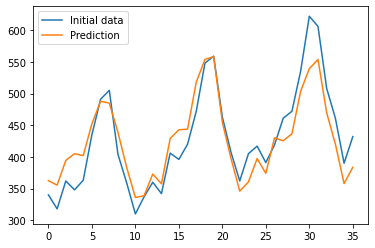

In [44]:
plt.plot(scaler.inverse_transform(yTest.reshape(-1, 1)), label='Initial data')
plt.plot(pred, label='Prediction')
plt.legend()
plt.show()